In [ ]:
# !fusermount -u /content/drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from scipy import stats

train = pd.read_csv('/content/drive/MyDrive/github_folder/house_price_prediction_only_spatial_data/train_data.csv')
test = pd.read_csv('/content/drive/MyDrive/github_folder/house_price_prediction_only_spatial_data/test_data.csv')

In [ ]:
X_train = train.drop(['id', 'price'], axis = 1)
y_train = train['price']
target = np.array(train['price'])
total_data = train

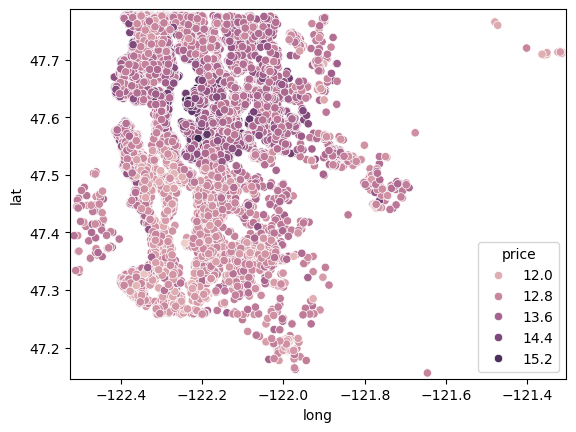

In [ ]:
latitude = X_train['lat']
longtitude = X_train['long']
lim_x = (min(longtitude)-0.01, max(longtitude)+0.01)
lim_y = (min(latitude)-0.01, max(latitude)+0.01)
target = np.log(y_train)

fig, ax = plt.subplots()
sns.scatterplot(x = longtitude, y = latitude,
                hue = target)
ax.set_xlim(lim_x)
ax.set_ylim(lim_y)
plt.show()

In [ ]:
class Calculator:
    def __init__(self, option, target):
        self.target = target
        self.operations = {
            "mean": self.calculate_mean,
            "variance": self.calculate_variance,
            "median": self.calculate_median,
            "mode": self.calculate_mode
        }

        if option in self.operations:
            self.result = self.operations[option]
        else:
            raise ValueError(f"Invalid option: {option}")

    def calculate_mean(self):
        return np.mean(self.target)

    def calculate_variance(self):
        return np.var(self.target)

    def calculate_median(self):
        return np.median(self.target)

    def calculate_mode(self):
        mode_result = stats.mode(self.target)
        return mode_result.mode[0]

In [ ]:
target_data = np.array([1, 2, 2, 3, 4])
calc = Calculator("mean", target_data)
print(calc.result())  # 2.4

2.4


In [ ]:
class SquareAreaExtractor:
    def __init__(self, x, y):
        self.lim_x = (min(x), max(x))
        self.lim_y = (min(y), max(y))

    def divide_space(self, num_interval):
        x_linspace = np.linspace(self.lim_x[0], self.lim_x[1], num_interval)
        y_linspace = np.linspace(self.lim_y[0], self.lim_y[1], num_interval)
        x_grid, y_grid = np.meshgrid(x_linspace, y_linspace)
        return x_grid, y_grid, num_interval

    def calculate_area(self, num_interval, x_area, y_area, targetdata, option):
        x_grid, y_grid, num_interval = self.divide_space(num_interval)
        indicator = np.zeros((num_interval-1, num_interval-1), dtype= np.int64)

        index_list = []
        area_list = []
        option_list = []

        for i in range(0, num_interval - 1):
            for j in range(0, num_interval - 1):
                x_lb, x_ub = x_grid[0][i], x_grid[0][i + 1]
                y_lb, y_ub = y_grid[j][0], y_grid[j + 1][0]

                condition1 = (x_area < x_ub) & (x_area >= x_lb)
                condition2 = (y_area < y_ub) & (y_area >= y_lb)
                condition = condition1 & condition2

                if sum(condition) >= (targetdata.shape[0] / (num_interval - 1)**2):
                    indicator[i][j] = int(1)
                    subdata = np.array(targetdata[condition])
                    res = Calculator(option, subdata).result()

                    index_tuple = ((i, i + 1), (j, j + 1))
                    area_tuple = ((x_lb, x_ub),(y_lb, y_ub))

                    index_list.append(index_tuple)
                    area_list.append(area_tuple)
                    option_list.append(res)

        return index_list, area_list, option_list

    def get_k_indices(self, num_interval, x_area, y_area, targetdata, option, k, descending = True):
        if descending:
            order = -1
        else: order = 1
        index_list, area_list, option_list = self.calculate_area(num_interval, x_area, y_area, targetdata, option)

        index_array, area_array, option_array = np.array(index_list), np.array(area_list), np.array(option_list)

        idxarr_updated = index_array[np.argsort(option_array)][::order][: k]
        areaarr_updated = area_array[np.argsort(option_array)][::order][: k]

        return idxarr_updated, areaarr_updated

In [ ]:
def draw_rectangular(area_array, x_area, y_area, target):
    x = x_area
    y = y_area

    lim_x = (min(x) - 0.01, max(x) + 0.01)
    lim_y = (min(y) - 0.01, max(y) + 0.01)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(lim_x)
    ax.set_ylim(lim_y)
    ax = sns.scatterplot(x = x_area, y = y_area,
                hue = target)
    for area in area_array:
        x, y = area[0][0], area[1][0]
        width = area[0][1] - area[0][0]
        height = area[1][1] - area[1][0]

        rect = patches.Rectangle(
                (x, y),
                width, height,
                edgecolor = 'r',
                facecolor = 'none')

        ax.add_patch(rect)
    plt.show()

In [ ]:
extractor = SquareAreaExtractor(longtitude, latitude)
idxarr, areaarr = extractor.get_k_indices(30,
                                          longtitude,
                                          latitude,
                                          target,
                                          option = 'mean',
                                          k = 50,
                                          descending = True)
draw_rectangular(areaarr, X_train['long'], X_train['lat'], target)

In [ ]:
def LineProjecter(start, end, x, y, double_sided = False):
    d = np.array(end) - np.array(start)
    w = np.array([-d[1], d[0]])
    position_list = []
    projected_list = []
    if double_sided:
        for i in range(x.shape[0]):
            point = np.array([x[i], y[i]])
            dot_product = np.dot(w, point - np.array(start))

            if dot_product >= 0:
                position_list.append(1)
            else:
                position_list.append(0)

            proj = np.dot(d, point) / np.dot(d, d)
            projected_list.append(proj)
    else:
        for i in range(x.shape[0]):
            point = np.array([x[i], y[i]])
            proj = np.dot(d, point) / np.dot(d, d)
            projected_list.append(proj)
    return position_list, projected_list

In [ ]:
def draw_line(start, end, x_area, y_area, target):
    x = x_area
    y = y_area

    lim_x = (min(x) - 0.01, max(x) + 0.01)
    lim_y = (min(y) - 0.01, max(y) + 0.01)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(lim_x)
    ax.set_ylim(lim_y)
    ax = sns.scatterplot(x = x_area, y = y_area,
                hue = target)

    start_x, start_y = start
    end_x, end_y = end
    slope = (end_y - start_y) / (end_x - start_x)
    intercept = start_y - slope * start_x

    line_x = np.array(lim_x)
    line_y = slope * line_x + intercept

    ax.plot(line_x, line_y, color='r', linestyle='-', linewidth=1)

    plt.show()

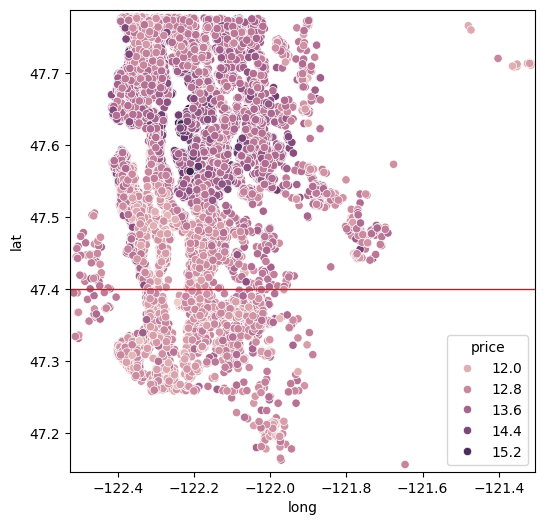

In [ ]:
draw_line((min(x), y), (max(x), y), X_train['long'], X_train['lat'], target)

In [ ]:
d = np.array([3,5])
np.linalg.norm(d)

5.830951894845301

In [ ]:
x = X_train['long'][:10]
y = 47.4

LineProjecter((min(x), y), (max(x), y), X_train['long'][:10], X_train['lat'][:10], True)

([1, 1, 1, 1, 1, 0, 1, 0, 0, 0],
 [-317.9869791666664,
  -317.6874999999998,
  -318.6796874999998,
  -318.6874999999998,
  -318.6458333333331,
  -317.9453124999997,
  -317.8203124999998,
  -317.8802083333331,
  -318.29427083333303,
  -318.5026041666664])